In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [13]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
features_ = pd.read_csv('../upperTriCorr.csv', index_col=0).set_index('participant_id')

In [4]:
targets_ = pd.read_csv('/home/jovyan/shared/ds003097/participants.tsv', delimiter='\t').set_index('participant_id')
targets_ = targets_.loc[features_.index]
targets_ = targets_[['BAS_drive', 'BAS_fun', 'BAS_reward', 'BIS']]
targets_['score'] = targets_.sum(axis=1)

In [7]:
def get_score(max_depth, features, targets):
    predictions, truths = [], []
    for sub_id in features.index:
        indexer = features.index == sub_id
        X_train, y_train = features.loc[~indexer], targets.loc[~indexer]['score']
        X_test,  y_test = features.loc[indexer], targets.loc[indexer]['score']
        
        scaler = MinMaxScaler()
        y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
        
        regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
        regr.fit(X_train, y_train)
        prediction = regr.predict(X_test)
        predictions.append(prediction)
        truths.append(y_test)

    predictions = np.array(predictions).reshape(-1)
    truths = np.array(truths).reshape(-1)
    return r2_score(truths, predictions)


In [8]:
for max_depth in [1, 2, 3, 4, 5, 6, 7, 8]:
    score = get_score(max_depth, features_, targets_)
    print(f'max_depth = {max_depth}, r^2 = {score:.4f}')

max_depth = 1, score = 0.1314
max_depth = 2, score = 0.1097
max_depth = 3, score = 0.1275
max_depth = 4, score = 0.1296
max_depth = 5, score = 0.1289
max_depth = 6, score = 0.1289
max_depth = 7, score = 0.1289
max_depth = 8, score = 0.1289


#### We will choose max_depth = 1

## Permutation Test

In [21]:
rng = np.random.default_rng(0)

scores = []
for _ in tqdm(range(100)):
    indexes = list(range(len(features_)))
    rng.shuffle(indexes)
    if indexes == list(range(len(features_))):
        continue
    targets = targets_.iloc[indexes]
    score = get_score(1, features_, targets)
    scores.append(score)


  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 1.,  3.,  4., 16., 13., 15., 21., 18.,  7.,  2.]),
 array([-0.17323995, -0.13049583, -0.0877517 , -0.04500757, -0.00226344,
         0.04048068,  0.08322481,  0.12596894,  0.16871307,  0.2114572 ,
         0.25420132]),
 <BarContainer object of 10 artists>)

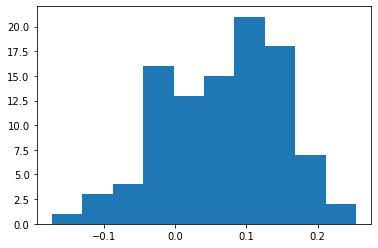

In [16]:
fig, ax = plt.subplots()
ax.hist(scores)

In [ ]:
len(list(filter(lambda x: x > 0.1314, scores))) / len(scores)